### Load data

In [ ]:
import torch

if torch.cuda.is_available():
    print("CUDA(GPU)를 사용할 수 있습니다.")
    device = torch.device("cuda")
else:
    print("CUDA(GPU)를 사용할 수 없습니다. CPU를 사용합니다.")
    device = torch.device("cpu")

CUDA(GPU)를 사용할 수 있습니다.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

train_data, val_data, test_data = np.load('/content/drive/MyDrive/Colab Notebooks/train_data.npz'), np.load('/content/drive/MyDrive/Colab Notebooks/val_data.npz'), np.load('/content/drive/MyDrive/Colab Notebooks/test_data.npz')

In [ ]:
# get the image, mask and labels

X_train, masks_train, y_train = train_data['images'], train_data['masks'], train_data['labels']
X_val, masks_val, y_val = val_data['images'], val_data['masks'], val_data['labels']
X_test, masks_test, y_test = test_data['images'], test_data['masks'], test_data['labels']

In [ ]:
print(X_train.shape, masks_train.shape, y_train.shape)
print(X_val.shape, masks_val.shape, y_val.shape)
print(X_test.shape, masks_test.shape, y_test.shape)

(1872, 500, 500, 1) (1872, 500, 500, 1) (1872,)
(78, 500, 500, 1) (78, 500, 500, 1) (78,)
(78, 500, 500, 1) (78, 500, 500, 1) (78,)


### U-Net model

In [ ]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import os

In [ ]:
checkpoint_path = '/content/drive/MyDrive/unet_model_epoch_5'
if os.path.exists(checkpoint_path):
    torch.load(checkpoint_path)
    print(f"'{checkpoint_path}' loaded")

'/content/drive/MyDrive/unet_model_epoch_5' loaded


In [ ]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Dropout(0.3)
                )
        return block

    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                    torch.nn.Dropout(0.3)
                    )
            return  block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.Sigmoid()
                    )
            return  block

    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encoder
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
                            torch.nn.Dropout(0.3)
                            )
        # Decoder
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)

    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        final_layer = self.final_layer(decode_block1)
        return  final_layer

In [ ]:
unet = UNet(in_channel=1,out_channel=1)
optimizer = torch.optim.Adam(unet.parameters(), lr = 0.01)

In [ ]:
criterion = torch.nn.BCELoss()

### Train model

In [ ]:
X_train = torch.from_numpy(X_train).float() # convert numpy array to tensor
X_val = torch.from_numpy(X_val).float()
X_test = torch.from_numpy(X_test).float()

masks_train = torch.from_numpy(masks_train).float()
masks_val = torch.from_numpy(masks_val).float()
masks_test = torch.from_numpy(masks_test).float()


X_train = X_train.permute(0, 3, 1, 2) # convert dim to [1872, 1, 500, 500]
X_val = X_val.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

masks_train = masks_train.permute(0, 3, 1, 2)
masks_val = masks_val.permute(0, 3, 1, 2)
masks_test = masks_test.permute(0, 3, 1, 2)

print(X_train.shape)
print(masks_train.shape)

torch.Size([1872, 1, 500, 500])
torch.Size([1872, 1, 500, 500])


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 8

# combine X_train and masks_train to randomly load batch size amount of the data
train_dataset = TensorDataset(X_train, masks_train)
val_dataset = TensorDataset(X_val, masks_val)
test_dataset = TensorDataset(X_test, masks_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for batch in train_dataloader:
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([8, 1, 500, 500])
Target shape: torch.Size([8, 1, 500, 500])


In [ ]:
def IoU(outputs, masks):
    intersection = torch.logical_and(outputs, masks).sum()
    union = torch.logical_or(outputs, masks).sum()
    iou = intersection.float() / union.float()
    return iou.item()

In [ ]:
for inputs, targets in train_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)

for inputs, targets in val_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)

for inputs, targets in test_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)

In [ ]:
class Trainer:
    def __init__(self, model, num_epochs, optimizer, criterion, early_stopping_patience):
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.model = model
        self.log_interval = 8

        self.train_losses = []
        self.val_losses = []
        self.train_iou = []
        self.val_iou = []

        self.best_model = None
        self.best_iou = 0.0
        self.best_epoch = 0

        self.early_stopping_patience = early_stopping_patience
        self.epochs_no_improve = 0

    def save_best_model(self, epoch, iou):
        if iou > self.best_iou:
            self.best_iou = iou
            self.best_epoch = epoch
            self.best_model = self.model.state_dict()

            filename = 'unet_model_best.pth'
            torch.save(self.best_model, filename)

    def train(self, train_dataloader, val_dataloader):

        for epoch in range(self.num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            train_iou = 0.0
            val_iou = 0.0

            # Training loop
            for i, (images, masks) in enumerate(train_dataloader):

                self.model.train()
                self.optimizer.zero_grad()

                outputs = self.model(images)
                masks_resized = F.interpolate(masks, size=(412, 412), mode='nearest')
                loss = self.criterion(outputs, masks_resized)
                iou = IoU(outputs, masks_resized)

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_iou += iou

                if (i + 1) % self.log_interval == 0:
                    print(f'Epoch [{epoch + 1}/{self.num_epochs}], Step [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}, IoU: {iou:.4f}')

            # Validation loop
            self.model.eval()
            with torch.no_grad():
                for images, masks in val_dataloader:
                    outputs = self.model(images)
                    masks_resized = F.interpolate(masks, size=(412, 412), mode='nearest')
                    val_loss += self.criterion(outputs, masks_resized).item()
                    val_iou += IoU(outputs, masks_resized)

            avg_train_loss = train_loss / len(train_dataloader)
            avg_val_loss = val_loss / len(val_dataloader)
            avg_train_iou = train_iou / len(train_dataloader)
            avg_val_iou = val_iou / len(val_dataloader)

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train IoU: {avg_train_iou:.4f}, Val IoU: {avg_val_iou:.4f}')

            # save metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_iou.append(avg_train_iou)
            self.val_iou.append(avg_val_iou)

            # save the latest model
            checkpoint = {"state_dict": self.model.state_dict(),
                          "optimizer": self.optimizer.state_dict(),
                          "epoch": epoch,
                          "train_losses": self.train_losses,
                          "train_iou": self.train_iou,
                          "best_iou": self.best_iou,
                          "best_model": self.best_model,
                          "best_epoch": self.best_epoch,
                          "epochs_no_improve": self.epochs_no_improve,
                          "val_losses": self.val_losses,
                          "val_iou": self.val_iou}
            torch.save(checkpoint, f"unet_model_epoch_{epoch+1}")

            # save best model
            self.save_best_model(epoch+1, avg_val_iou)

            # early stopping
            if avg_val_iou <= self.best_iou:
                self.epochs_no_improve += 1
                if self.epochs_no_improve == self.early_stopping_patience:
                    print(f"early stopping: no improvement on epoch {epoch + 1}")
                    break
            else:
                self.epochs_no_improve = 0

    def get_metrics(self):
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_iou': self.train_iou,
            'val_iou': self.val_iou,
            'best_epoch': self.best_epoch,
            'best_iou': self.best_iou
        }

In [ ]:
trainer = Trainer(model=unet, num_epochs=10, optimizer=optimizer, criterion=criterion, early_stopping_patience=5)

Trial 1. (Dropout=0.2, Optimizer=Adam, Learning rate = 0.005, Batch size = 8)
: IoU doesn't change on training and validation data.

Trial 2. (Dropout=0.2, Optimizer=Adam, Learning rate = 0.01, Batch size = 8): Changed learning rate, but IoU stays the same.

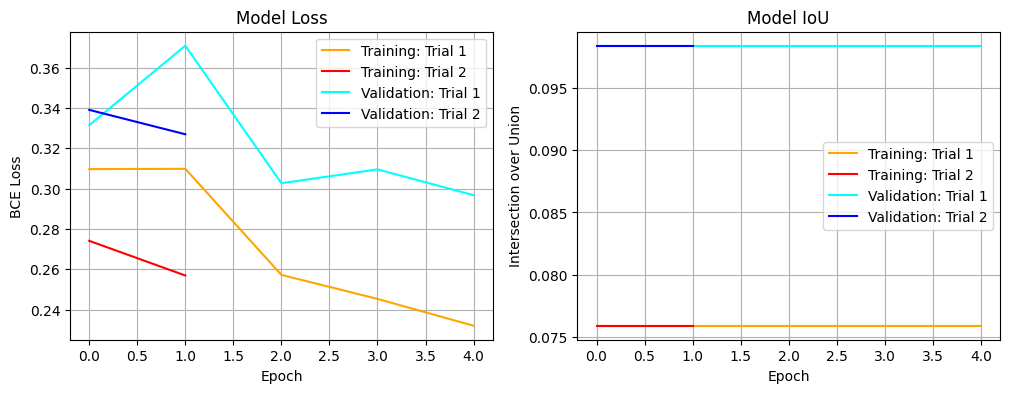

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title("Model Loss")
training_loss_tria11 = [0.3097, 0.3098560772263087, 0.25721290093074495, 0.24529568860546136, 0.23197934477247745]
validation_loss_trial1 = [0.3315, 0.37093970775604246, 0.3027065932750702, 0.3095615491271019, 0.29678146690130236]
training_loss_trial2 = [0.2741, 0.2569]
validation_loss_trial2 = [0.3391, 0.3270]
plt.plot(training_loss_tria11, label="Training: Trial 1", c='orange')
plt.plot(training_loss_trial2, label="Training: Trial 2", c='red')
plt.plot(validation_loss_trial1, label="Validation: Trial 1", c='cyan')
plt.plot(validation_loss_trial2, label="Validation: Trial 2", c='blue')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.title("Model IoU")
training_iou_trial1 = [0.0759, 0.0759, 0.0759, 0.0759, 0.0759]
training_iou_trial2 = [0.0759, 0.0759]
validation_iou_trial1 = [0.0984, 0.0984, 0.0984, 0.0984, 0.0984]
validation_iou_trial2 = [0.0984, 0.0984]
plt.plot(training_iou_trial1, label="Training: Trial 1", c='orange')
plt.plot(training_iou_trial2, label="Training: Trial 2", c='red')
plt.plot(validation_iou_trial1, label="Validation: Trial 1", c='cyan')
plt.plot(validation_iou_trial2, label="Validation: Trial 2", c='blue')
plt.xlabel('Epoch')
plt.ylabel('Intersection over Union')
plt.legend()
plt.grid()

plt.show()

In [ ]:
trainer.train(train_dataloader, val_dataloader)
metrics = trainer.get_metrics()

Epoch [1/10], Step [8/234], Loss: 0.6175, IoU: 0.0325
Epoch [1/10], Step [16/234], Loss: 0.3031, IoU: 0.0595
Epoch [1/10], Step [24/234], Loss: 0.1538, IoU: 0.0306
Epoch [1/10], Step [32/234], Loss: 0.4636, IoU: 0.0993
Epoch [1/10], Step [40/234], Loss: 0.2551, IoU: 0.0629
Epoch [1/10], Step [48/234], Loss: 0.3244, IoU: 0.0931
Epoch [1/10], Step [56/234], Loss: 0.3158, IoU: 0.1045
Epoch [1/10], Step [64/234], Loss: 0.3091, IoU: 0.0932
Epoch [1/10], Step [72/234], Loss: 0.3846, IoU: 0.1391
Epoch [1/10], Step [80/234], Loss: 0.2269, IoU: 0.0590
Epoch [1/10], Step [88/234], Loss: 0.3704, IoU: 0.0774
Epoch [1/10], Step [96/234], Loss: 0.2577, IoU: 0.0738
Epoch [1/10], Step [104/234], Loss: 0.2670, IoU: 0.0528
Epoch [1/10], Step [112/234], Loss: 0.1901, IoU: 0.0415
Epoch [1/10], Step [120/234], Loss: 0.1954, IoU: 0.0501
Epoch [1/10], Step [128/234], Loss: 0.3001, IoU: 0.1051
Epoch [1/10], Step [136/234], Loss: 0.2570, IoU: 0.0775
Epoch [1/10], Step [144/234], Loss: 0.3259, IoU: 0.1079
Epoch

In [ ]:
print(trainer.train_losses)
print(trainer.val_losses)
print(trainer.train_iou)
print(trainer.val_iou)

[0.2879638123588684, 0.2617200378678803, 0.25214728684379506, 0.23073165064566156, 0.21699534359778094]
[3.475899362564087, 5.195149350166321, 3.827957475185394, 0.4447570860385895, 0.3912498772144318]
[0.07592406757494323, 0.07592477980587217, 0.07592407138779378, 0.07592406750330304, 0.0759355466788969]
[0.10504143536090851, 0.08713387213647365, 0.09341205358505249, 0.09838624484837055, 0.0986605480313301]


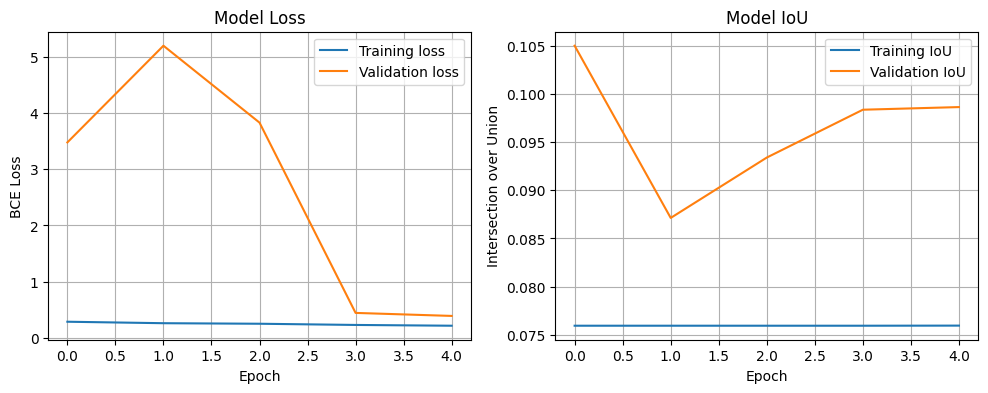

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title("Model Loss")
plt.plot(trainer.train_losses, label='Training loss')
plt.plot(trainer.val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.title("Model IoU")
plt.plot(trainer.train_iou, label='Training IoU')
plt.plot(trainer.val_iou, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('Intersection over Union')
plt.grid()
plt.legend()

plt.show()

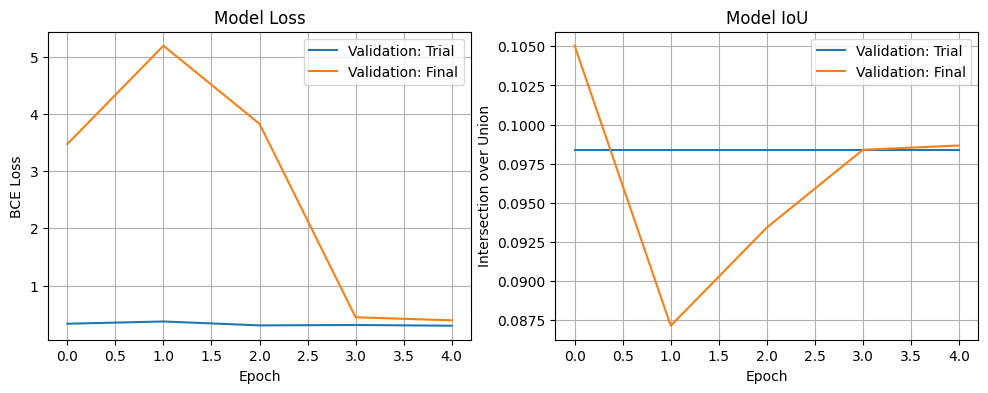

In [ ]:
import matplotlib.pyplot as plt

validation_loss_trial3 = [3.475899362564087, 5.195149350166321, 3.827957475185394, 0.4447570860385895, 0.3912498772144318]
validation_iou_trial3 = [0.10504143536090851, 0.08713387213647365, 0.09341205358505249, 0.09838624484837055, 0.0986605480313301]

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title("Model Loss")
plt.plot(validation_loss_trial1, label="Validation: Trial")
plt.plot(validation_loss_trial3, label="Validation: Final")
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.title("Model IoU")
plt.plot(validation_iou_trial1, label="Validation: Trial")
plt.plot(validation_iou_trial3, label="Validation: Final")
plt.xlabel('Epoch')
plt.ylabel('Intersection over Union')
plt.grid()
plt.legend()

plt.show()

Segmentation of Test data

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import torch
import numpy as np

unet = unet.to(device)
unet.eval()

y_true, y_scores = [], []
test_loss = 0.00
test_iou = 0.00

with torch.no_grad():
    for images, masks in test_dataloader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = unet(images)
        masks_resized = F.interpolate(masks, size=(412, 412), mode='nearest')
        masks_resized_binary = masks_resized > 0.5

        y_true.append(masks_resized_binary.cpu().numpy().flatten())
        y_scores.append(outputs.cpu().numpy().flatten())

        test_loss += criterion(outputs, masks_resized).item()
        test_iou += IoU(outputs, masks_resized)

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

ap = average_precision_score(y_true, y_scores)

avg_test_loss = test_loss / len(test_dataloader)
avg_test_iou = test_iou / len(test_dataloader)

print('Average Precision on Test Data:', ap)
print('Average BCE Loss on Test Data:', avg_test_loss)
print('Average IoU on Test Data:', avg_test_iou)

Average Precision on Test Data: 0.11811134799861792
Average BCE Loss on Test Data: 0.6886296272277832
Average IoU on Test Data: 0.09249254241585732


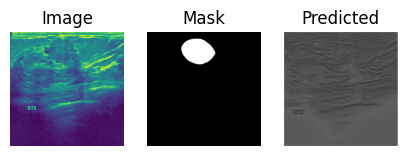

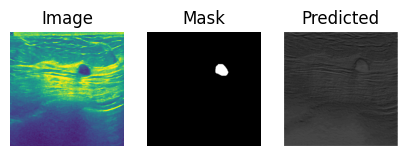

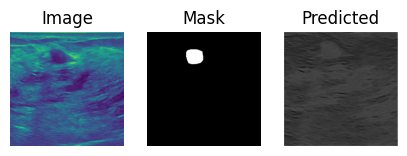

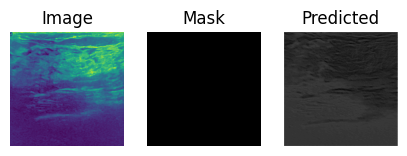

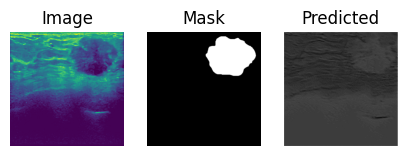

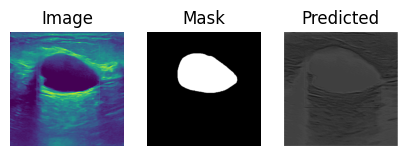

In [ ]:
unet.eval()
unet.to(device)

for i in [3, 12, 48, 51, 66, 77]:
    image = test_dataset[i][0]
    mask = test_dataset[i][1]
    im = image.to(device)
    pred = unet(im.unsqueeze(0))
    pred = pred.squeeze()

    plot_subplots(im, mask, pred)